 
# <span style="color:mediumblue">Concrete ML in action</span>


In the first demo, we showcase how to use build-in models, including: linear and tree-based models, using Concrete ML library.

For the second demo, we walk-though the process of converting custom Torch neural network to its FHE-equivalent.
( For NN, I'll walk you through the process in the second demo)


For each Concrete ML model, we will compare its execution time and performance to the standard scikit-learn counterpart.

# <span style="color:lightblue">Your Title</span>
# <span style="color:skyblue">Your Title</span>
# <span style="color:dodgerblue">Your Title</span>
# <span style="color:royalblue">Your Title</span>
# <span style="color:mediumblue">Your Ti!tle</span>
# <span style="color:darkblue">Your Title</span>

##### <span style="color:skyblue">Import required libraries</span>

In [1]:
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from brevitas.nn import QuantLinear, QuantReLU
from brevitas.quant import Int8ActPerTensorFloat, Int8WeightPerTensorFloat
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from utils_demo import (
    CustomDataset,
    CustomNeuralNet,
    plot_data,
    plot_datasets,
    plot_decision_boundary,
)

%matplotlib inline

### <span style="color:skyblue">Generate synthetic data-set</span>

We generate 3 synthetic data-sets for this demo. Where: 
- the first dataset is generated through make_classification, and it will be used for the linear model example
- the second a bit more complex is been generated through make_moons, which will be used for the tree-based model example.
- and finally the last dataset is generated using make circles that we will use for the neural network example.

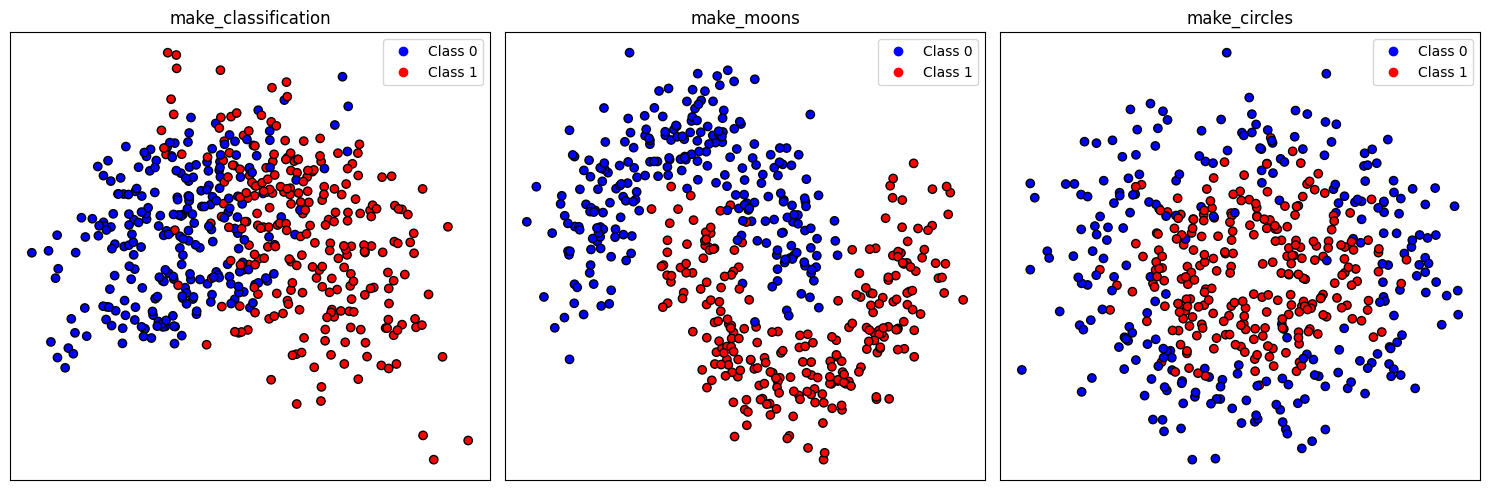

In [2]:
linear_dataset, moon_dataset, circle_dataset = plot_datasets()

## <span style="color:royalblue">1. Linear models</span>

Gentle reminder:

Linear models are a family of algorithms in ML that aim to establish a linear relationship between input features and the target variable. So that the prediction is a weighted sum of the input features, to which a bias term can be added. 

The objective is to find the best weights and bias that minimize the difference between predicted and actual target values.
They are well-known for the simplicity and can be employed for regression and classification taskes. We can mention :
- Linear Regression
- Logistic Regression
- linear-kernel Support Vector Machines (SVM).

In this demo, I have selected logistic regression for a classification task.

In [3]:
# Split the data-set into a train and testing sets
X_train, X_test, y_train, y_test = train_test_split(*linear_dataset, test_size=0.2, random_state=42)

# Shape
X_train.shape, X_test.shape

((400, 2), (100, 2))

### <span style="color:dodgerblue">1.1 Logistic Regression with scikit-learn</span>

Scikit-learn accuracy: 84.00%


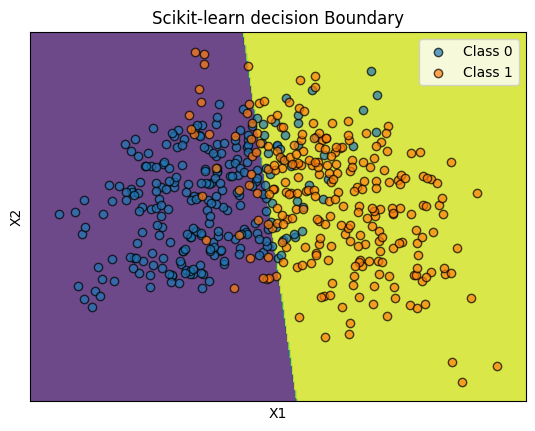

In [4]:
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression

# Instanciate the model
sklearn_logit = SklearnLogisticRegression()

# Fit the model
sklearn_logit.fit(X_train, y_train)

# Predict
y_pred = sklearn_logit.predict(X_test)

# Evaluate the model
sklearn_accuracy = accuracy_score(y_test, y_pred)
print(f"Scikit-learn accuracy: {sklearn_accuracy:.2%}")

# Plot decision boundary
plot_decision_boundary(sklearn_logit, linear_dataset, "Scikit-learn")

### <span style="color:dodgerblue">1.2 Logistic Regression with Concrete ML</span>

Execution time in fhe: 0.0004 seconds per sample
Concrte ML accuracy with 8-bits: 84.00%


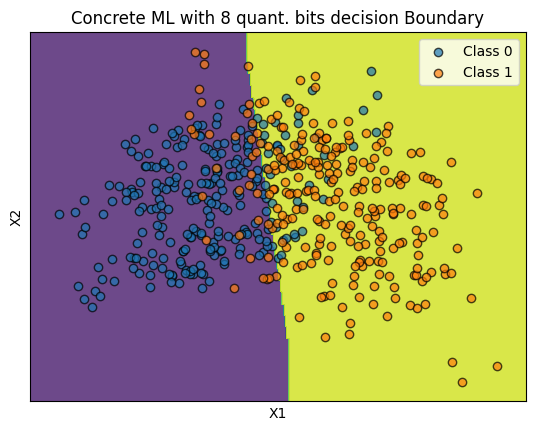

In [5]:
from concrete.ml.sklearn import LogisticRegression as ConcreteLogisticRegression

# 1. Instanciate the model
# ConcreteLogisticRegression has the same attributes and methods as SklearnLogisticRegression
# The additional hyper-parameter is `n_bits` used for the quantization
# The quantization is done through PTQ approach
concrete_logit = ConcreteLogisticRegression(n_bits=8)

# 2. The `fit` method is the same as the scikit-learn one
concrete_logit.fit(X_train, y_train)

# 3. compilation
# It allows you to:
# - create the operational graph (in our jargon we call it a circuit)
# - Generate he crypto parameters
# - check if the circuit is if the circuit is compliant with the FHE requirements
#       - bit-width inside the circuit must be less than 16-bits
#       - all intermediate values are properly quantized

# You need to provide an exhaustive set of data to evaluate the maximum integer bit-width within the graph
# which is needed during FHE computations before running any predictions.
# You can either provide the entire trained data-set or a smaller but representative subset.
fhe_circuit = concrete_logit.compile(X_train)

# Generate the keys
fhe_circuit.client.keygen(force=False)

# FHE inference
time_begin = time.time()
y_pred_fhe = concrete_logit.predict(X_test, fhe="execute")
print(f"Execution time in fhe: {(time.time() - time_begin) / len(X_test):.4f} seconds per sample")

fhe_accuracy = accuracy_score(y_test, y_pred_fhe)
print(f"Concrte ML accuracy with {concrete_logit.n_bits}-bits: {fhe_accuracy:.2%}")

plot_decision_boundary(
    concrete_logit, linear_dataset, f"Concrete ML with {concrete_logit.n_bits} quant. bits"
)

In [6]:
## Concrete ML vs scikit-learn:
print(f"Concrete ML accuracy: {fhe_accuracy:.2%} VS scikit-learn accuracy: {sklearn_accuracy:.2%}")

Concrete ML accuracy: 84.00% VS scikit-learn accuracy: 84.00%


Let's check the effect of the quantization on the decision boundary with `n_bits = 3`.

In [7]:
## Concrete ML vs scikit-learn:
print(f"Concrete ML accuracy: {fhe_accuracy:.2%} VS scikit-learn accuracy: {sklearn_accuracy:.2%}")

Concrete ML accuracy: 84.00% VS scikit-learn accuracy: 84.00%


## <span style="color:royalblue">2. Tree-based models</span>

Gentle reminder:

Tree models are a class of machine learning algorithms that use a tree-like structure to make decisions based on input features. They recursively split the data into subsets, where each subset represents a branch or node in the tree. These models are commonly used for both regression and classification tasks. Tree models, such as Decision Trees and Random Forests, are interpretable and can capture non-linear relationships in the data. They partition the feature space into distinct regions, making them suitable for handling complex decision boundaries and handling missing values.


In [8]:
# Split the data-set into a train and testing sets
X_train, X_test, y_train, y_test = train_test_split(*moon_dataset, test_size=0.2, random_state=42)

# Shape
X_train.shape, X_test.shape

((400, 2), (100, 2))

### <span style="color:dodgerblue">1.1 Tree-based models with scikit-learn</span>

Scikit-learn accuracy: 97.00%


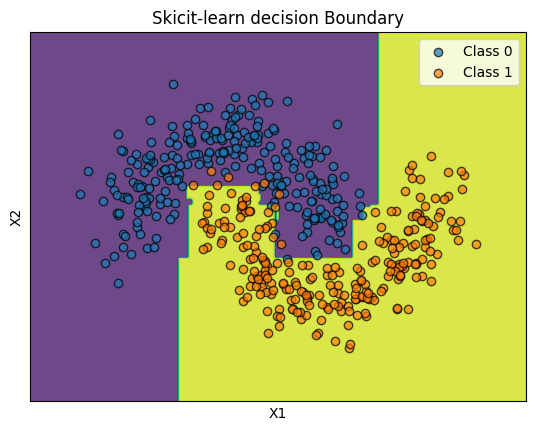

In [9]:
from xgboost.sklearn import XGBClassifier as SklearnXGBClassifier

# Instanciate the model
sklearn_trees = SklearnXGBClassifier(random_state=727)

# Fit the model
sklearn_trees.fit(X_train, y_train)

# Predict
y_pred = sklearn_trees.predict(X_test)

# Evaluate the model
sklearn_accuracy = accuracy_score(y_test, y_pred)
print(f"Scikit-learn accuracy: {sklearn_accuracy:.2%}")

# Plot decision boundary
plot_decision_boundary(sklearn_trees, moon_dataset, "Skicit-learn")

### <span style="color:dodgerblue">1.2 Tree-based models with Concrete ML</span>

Compilation time: 0.41 s

Execution time in FHE: 0.6338 seconds per sample



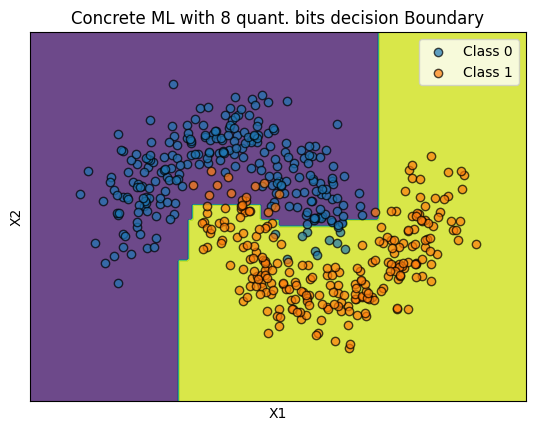

In [10]:
from concrete.ml.sklearn import XGBClassifier as ConcreteXGBClassifier

# Quantization with Post Taining Quantization approach
concrete_trees = ConcreteXGBClassifier(n_bits=8)

# Fit the model using scikit-learn fit method
concrete_trees.fit(X_train, y_train)

# Compile the model
time_begin = time.time()
fhe_circuit = concrete_trees.compile(X_train)
print(f"Compilation time: {(time.time() - time_begin):.2f} s\n")

# generate the keys
fhe_circuit.client.keygen(force=False)

# Real FHE mode
time_begin = time.time()
y_pred_fhe = concrete_trees.predict(X_test[0, None], fhe="execute")
print(f"Execution time in FHE: {(time.time() - time_begin) / len(X_test):.4f} seconds per sample\n")

# Predict
y_pred_fhe = concrete_trees.predict(X_test, fhe="simulate")
fhe_accuracy = accuracy_score(y_test, y_pred_fhe)

plot_decision_boundary(
    concrete_trees, moon_dataset, f"Concrete ML with {concrete_logit.n_bits} quant. bits"
)

In [11]:
print(f"Concrete ML accuracy: {fhe_accuracy:.2%} VS Scikit-learn accuracy: {sklearn_accuracy:.2%}")

Concrete ML accuracy: 93.00% VS Scikit-learn accuracy: 97.00%


Let's check the effect of the quantization on the decision boundary with `n_bits = 2`.

Concrete ML accuracy: 90.00% VS Scikit-learn accuracy: 97.00%


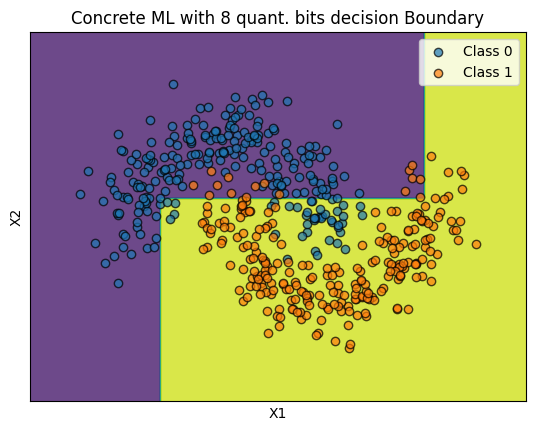

In [12]:
concrete_trees = ConcreteXGBClassifier(n_bits=2)

concrete_trees.fit(X_train, y_train)

fhe_circuit = concrete_trees.compile(X_train)

fhe_circuit.client.keygen(force=False)

y_pred = concrete_trees.predict(X_test, fhe="simulate")

fhe_accuracy = accuracy_score(y_test, y_pred)

print(f"Concrete ML accuracy: {fhe_accuracy:.2%} VS Scikit-learn accuracy: {sklearn_accuracy:.2%}")

plot_decision_boundary(
    concrete_trees, moon_dataset, f"Concrete ML with {concrete_logit.n_bits} quant. bits"
)

## <span style="color:royalblue">3. Custom Neural Network </span>

I will show you how to convert any custom Torch neural network to its FHE-equivalent.

The development flow is as follows:

- You train your fp32 model, as you used to do 
- You quantize the model using the Brevitas library, in this demo, I've chosen the qat (quantization-aware training) approach.
- Then, you check if the quantized model complies with the FHE requirements before performing any computation to save time.
- I'll show 2 inference modes in practice: simulation mode and real FHE mode.

##### <span style="color:skyblue">Circle data-set</span>

In [13]:
# Split the data-set into a train and testing sets
X_train, X_test, y_train, y_test = train_test_split(*circle_dataset, test_size=0.2, random_state=42)

# Convert the data to PyTorch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test)

# Shape
X_train.shape, X_test.shape

(torch.Size([400, 2]), torch.Size([100, 2]))

##### <span style="color:skyblue">Import some helpers</span>

In [14]:
from utils_demo import CustomNeuralNet, QuantCustomModel, mapping_keys, torch_evaluation, train

# For the compilation
from concrete.ml.torch.compile import compile_brevitas_qat_model

##### <span style="color:skyblue">Hyper-parameters</span>

In [19]:
# Set the hyperparameters
neural_network_param = {"input_shape": 2, "output_shape": 2, "hidden_shape": 100}

device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##### <span style="color:skyblue">3.1 Train the FP32 model</span>

Let's take a live example.

Epoch [ 100 / 1000], Train Loss: 0.67, Test Loss: 0.69, Learning Rate: 0.0001
Epoch [ 200 / 1000], Train Loss: 0.65, Test Loss: 0.67, Learning Rate: 0.0001
Epoch [ 300 / 1000], Train Loss: 0.63, Test Loss: 0.65, Learning Rate: 0.0001
Epoch [ 400 / 1000], Train Loss: 0.60, Test Loss: 0.62, Learning Rate: 0.0001
Epoch [ 500 / 1000], Train Loss: 0.58, Test Loss: 0.60, Learning Rate: 0.0001
Epoch [ 600 / 1000], Train Loss: 0.55, Test Loss: 0.57, Learning Rate: 0.0001
Epoch [ 700 / 1000], Train Loss: 0.53, Test Loss: 0.54, Learning Rate: 0.0001
Epoch [ 800 / 1000], Train Loss: 0.50, Test Loss: 0.52, Learning Rate: 0.0001
Epoch [ 900 / 1000], Train Loss: 0.48, Test Loss: 0.49, Learning Rate: 0.0001
Epoch [1000 / 1000], Train Loss: 0.46, Test Loss: 0.47, Learning Rate: 0.0001

Train accuracy: 0.875 vs Test accuracy: 0.9


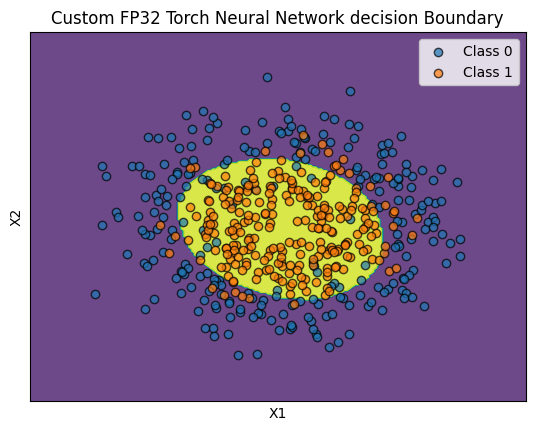

In [20]:
# Initialize the FP32 neural network
fp32_nn = CustomNeuralNet(**neural_network_param)

do_training = True

if do_training:
    train(fp32_nn, X_train, X_test, y_train, y_test, seed=42, step=100, epochs=1000, verbose=True)
else:
    fp32_nn.load_state_dict(torch.load("custom_fp32_state_dict.pt"))

# Plot the decision boundary
plot_decision_boundary(fp32_nn, circle_dataset, "Custom FP32 Torch Neural Network")

##### <span style="color:skyblue">3.2 Quantize the FP32 model using Brevitas library</span>

In [21]:
quantized_nn = QuantCustomModel(**neural_network_param, n_bits=4)

checkpoint = torch.load("custom_fp32_state_dict.pt")

quantized_nn = mapping_keys(checkpoint, quantized_nn, device)

# The accuracy drops
torch_evaluation(quantized_nn, X_test, y_test, device)

Accuracy: 0.74


##### <span style="color:skyblue">3.3 Fine-tune the quantized model</span>

In [22]:
# Using the same the same function, with less epochs
train(
    quantized_nn,
    X_train,
    X_test,
    y_train,
    y_test,
    learning_rate=0.1,
    epochs=100,
    verbose=1,
    milestones=[100],
)

Epoch [ 10 / 100], Train Loss: 0.47, Test Loss: 0.44, Learning Rate: 0.1
Epoch [ 20 / 100], Train Loss: 0.43, Test Loss: 0.38, Learning Rate: 0.1
Epoch [ 30 / 100], Train Loss: 0.39, Test Loss: 0.41, Learning Rate: 0.1
Epoch [ 40 / 100], Train Loss: 0.32, Test Loss: 0.36, Learning Rate: 0.1
Epoch [ 50 / 100], Train Loss: 0.31, Test Loss: 0.48, Learning Rate: 0.1
Epoch [ 60 / 100], Train Loss: 0.32, Test Loss: 0.38, Learning Rate: 0.1
Epoch [ 70 / 100], Train Loss: 0.30, Test Loss: 0.43, Learning Rate: 0.1
Epoch [ 80 / 100], Train Loss: 0.31, Test Loss: 0.46, Learning Rate: 0.1
Epoch [ 90 / 100], Train Loss: 0.31, Test Loss: 0.35, Learning Rate: 0.1
Epoch [100 / 100], Train Loss: 0.30, Test Loss: 0.38, Learning Rate: 0.010000000000000002

Train accuracy: 0.8675 vs Test accuracy: 0.89


##### <span style="color:skyblue">3.4 Check if the network is compliant</span>

In [23]:
# If you reminder, for the build-in models, we used to compile the model
# We will do the same, for the NNs, thanks to this function

qmodel = compile_brevitas_qat_model(
    quantized_nn.to("cpu"),
    # Calibration data
    torch_inputset=X_train,
)

print(
    "The maximum bit-width in the circuit = "
    f"{qmodel.fhe_circuit.graph.maximum_integer_bit_width()} bits"
)

The maximum bit-width in the circuit = 9 bits


##### <span style="color:skyblue">3.5 Inference in FHE</span>

In [ ]:
# Let's measue the time inference for 1 example

time_start = time.time()
fhe_y_pred = qmodel.forward(X_test.numpy()[0][None], fhe="execute")
print(f"Execution time in FHE: {(time.time() - time_start) / len(X_test):.4f} seconds per sample\n")

#### <span style="color:skyblue">Inference modes</span>

As you can see, the operations in Homomorphic Encryption can be quite costly. Actually it's proportional to the network size, input size, and precision bit-width in the circuit.

So, the Concrete ML library offers a cool feature, called **FHE simulation**. This simulation mimics the behavior of real Fully Homomorphic Encryption (FHE) computations, including the errors it could produce, while providing an oversight of the model's performance.

It's usefull for development phase, especially when several tests and iterations are required. 

##### <span style="color:skyblue">Inference in FHE simulation mode</span>

In [ ]:
fhe_y_pred = qmodel.forward(X_test.numpy(), fhe="simulate")

fhe_s_accuracy = (fhe_y_pred.argmax(1) == y_test.numpy()).mean()

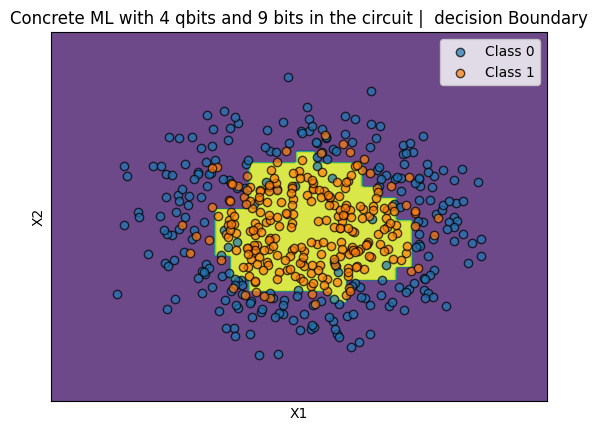

In [ ]:
title = (
    f"Concrete ML with {quantized_nn.n_bits} qbits and "
    f"{qmodel.fhe_circuit.graph.maximum_integer_bit_width()} bits in the circuit - "
)

plot_decision_boundary(quantized_nn, circle_dataset, title, qmodel)

## <span style="color:royalblue">3. Build-in Neural Network </span>

Gentle reminder: 

Neural networks are a class of machine learning models inspired by the structure and functioning of the human brain. They consist of interconnected nodes, called neurons, organized in layers. Each neuron takes inputs, applies weights and biases, and passes the result through an activation function. Neural networks are capable of learning complex patterns and relationships from data, making them powerful for various tasks, such as image recognition, natural language processing, and more.


### <span style="color:dodgerblue">1.1 Neural Network build-in model with scikit-learn</span>

In [ ]:
from sklearn.neural_network import MLPClassifier

neural_net_params = {
    "hidden_layer_sizes": (100, 2),
    "activation": "relu",
}

sklearn_nn = MLPClassifier(batch_size=32, **neural_net_params)

sklearn_nn.fit(X_train, y_train)

y_pred = sklearn_nn.predict(X_test)

sklearn_accuracy = accuracy_score(y_test, y_pred)

sklearn_accuracy

### <span style="color:dodgerblue">1.2 Neural Network build-in model with Concrete ML</span>

In [ ]:
from concrete.ml.sklearn import NeuralNetClassifier

neural_net_params = {
    "module__n_hidden_neurons_multiplier": 100,
    "module__n_layers": 2,  # 1 hidden layer
    "module__activation_function": torch.nn.ReLU,
    "module__n_w_bits": 7,
    "module__n_a_bits": 7,
    "module__n_accum_bits": 32,
    "verbose": 0,
}

concrete_nn = NeuralNetClassifier(batch_size=32, **neural_net_params)

concrete_nn.fit(X_train, y_train)

concrete_nn.compile(X_train)

y_pred_fhe = concrete_nn.predict(X_test, fhe="simulate")

fhe_accuracy = accuracy_score(y_test, y_pred_fhe)

fhe_accuracy